In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, metrics, activations
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalize(x):
  # Normalizes to [-1, 1]
  return (x - 127.5) / 127.5

In [3]:
# Loads data for MNIST

BATCH_SIZE = 64

(x_train, y_train), (x_validation, y_validation) = mnist.load_data()

x_validation, y_validation = x_validation[:500], y_validation[:500]

x_train, x_validation = normalize(x_train), normalize(x_validation)

x_train, x_validation = np.reshape(x_train, (x_train.shape[0], -1)), np.reshape(x_validation, (x_validation.shape[0], -1))

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
         .shuffle(buffer_size = 50_000) \
         .batch(BATCH_SIZE, drop_remainder=True)

In [4]:
# Prinsipper fra DCGAN:
# - Ikke bruk pooling: bruk i stedet konvolusjonelle lag med strides
# - Ikke bruk hidden dense lag (bruk altså bare konvolusjonelle lag i hidden lagene)
# - Bruk batch normalization etter hvert lag, utenom output-laget
#   til generatoren og input-laget til diskriminatoren
# - Bruk ReLU-aktivering for generatoren, med tanh i output-lag (jeg opplevde
#   imidlertid bedre resultater med LeakyReLU også for generatoren)
# - Bruk LeakyReLU-aktivering for diskrimatoren 

In [5]:
# Definer diskriminator-modellen fra DCGAN-arkitekturen. Denne baserer seg på
# Conv2D-lag. 

discriminator = Sequential([
    # (784)
    layers.Reshape((28, 28, 1), input_shape=(784,)),
    # (28, 28, 1)

    layers.Conv2D(32, (5, 5), strides=(2,2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    # (14, 14, 32)

    layers.Conv2D(64, (5, 5), strides=(2,2), padding="same", activation="LeakyReLU"),
    layers.BatchNormalization(),
    # (7, 7, 64)
    
    layers.Flatten(),
    # (7*7*64)

    layers.Dense(units = 1)
    # (1)                        
])

discriminator.compile(loss = losses.BinaryCrossentropy(from_logits=True))
discriminator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [6]:
noise_dim = 20

# Definer generator-modellen fra DCGAN-arkitekturen. Denne baserer seg på
# Conv2DTranspose-lag.

generator = Sequential([
    layers.BatchNormalization(input_shape = (noise_dim,)),
    layers.Dense(units = 64 * 7 * 7),
    layers.Reshape((7, 7, 64)),
    # (7, 7, 64)

    layers.Conv2DTranspose(64, kernel_size=(5,5), strides = (2, 2), padding="same", activation="ReLU"),
    layers.BatchNormalization(),
    # 14, 14, 64

    layers.Conv2DTranspose(1, kernel_size=(5,5), strides = (2, 2), padding="same", activation="tanh"),
    # 28, 28, 1
    layers.Flatten()
])


generator.compile(loss = losses.BinaryCrossentropy(from_logits = True))
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              65856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)              

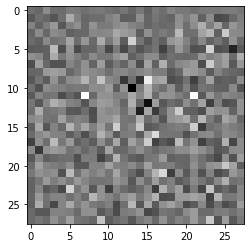

In [7]:
def to_image(img):
  return img.reshape([28, 28])

def show_image(img):
  img = to_image(img)
  plt.imshow(img, cmap='gray')
  plt.show()

def generate_noise(dim, batch_size = 1):
  return tf.random.normal([batch_size, dim])

# Generer og viser et bilde fra den utrente generatoren

generated_image = generator(generate_noise(noise_dim)).numpy()

show_image(generated_image)


In [8]:
# Definerer optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
# Her kan du bruke samme train_step som i forrige notebook

@tf.function
def train_step(real_images):
  noise = generate_noise(dim = noise_dim, batch_size = BATCH_SIZE)

  with tf.GradientTape(persistent=True) as tape:

    fake_images = generator(noise)

    prediction_real = discriminator(real_images)
    prediction_fake = discriminator(fake_images)

    discriminator_loss = losses.binary_crossentropy(y_true=tf.ones_like(prediction_real), y_pred=prediction_real, from_logits=True) + losses.binary_crossentropy(y_true=tf.zeros_like(prediction_fake), y_pred=prediction_fake, from_logits=True)
    generator_loss = losses.binary_crossentropy(y_true=tf.ones_like(prediction_fake), y_pred=prediction_fake, from_logits=True)

  gradients_of_generator = tape.gradient(generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  gradients_of_discriminator = tape.gradient(discriminator_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  P_real = tf.reduce_mean(activations.sigmoid(prediction_real))
  P_fake = 1 - tf.reduce_mean(activations.sigmoid(prediction_fake))

  return tf.reduce_mean(discriminator_loss), tf.reduce_mean(generator_loss), P_real, P_fake


In [10]:
def show_image_grid(images):
  N = images.shape[0]

  fig = plt.figure(figsize=(3, 3))
  fig.set_size_inches(10, 10)

  for i in range(N):
      plt.subplot(3, 3, i+1)
      img = to_image(images[i])
      plt.imshow(img, cmap="gray")
      plt.axis('off')

  plt.show()

Epoch 0
Step 0. Ld=1.3484563827514648, Lg=0.6925707459449768, Pr=0.5200080871582031, Pf=0.4997113347053528
Step 100. Ld=0.3420823812484741, Lg=1.3994230031967163, Pr=0.9434020519256592, Pf=0.7530585527420044
Step 200. Ld=0.1466166079044342, Lg=3.09964656829834, Pr=0.9390869140625, Pf=0.9240733981132507
Step 300. Ld=0.10886950045824051, Lg=4.22225284576416, Pr=0.9603418111801147, Pf=0.9476332664489746
Step 400. Ld=0.13572852313518524, Lg=3.132460594177246, Pr=0.9304161071777344, Pf=0.9472700357437134
Step 500. Ld=0.14904680848121643, Lg=3.3475849628448486, Pr=0.9114643931388855, Pf=0.9549020528793335
Step 600. Ld=0.26629638671875, Lg=2.7511091232299805, Pr=0.9211697578430176, Pf=0.8603877425193787
Step 700. Ld=0.06779792159795761, Lg=3.5789456367492676, Pr=0.9804576635360718, Pf=0.9560612440109253
Step 800. Ld=0.2864111065864563, Lg=3.8618383407592773, Pr=0.8393061757087708, Pf=0.9596512317657471
Step 900. Ld=0.14501211047172546, Lg=3.6494202613830566, Pr=0.9313664436340332, Pf=0.946839

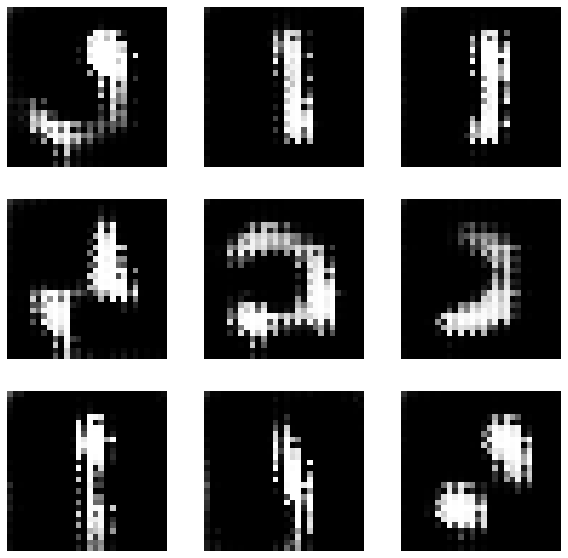

Epoch 1
Step 0. Ld=0.07548155635595322, Lg=3.7894914150238037, Pr=0.9780279397964478, Pf=0.9531956911087036
Step 100. Ld=0.3635345995426178, Lg=2.6078522205352783, Pr=0.8767282962799072, Pf=0.8756709694862366
Step 200. Ld=0.173211008310318, Lg=2.794569969177246, Pr=0.9714562296867371, Pf=0.8837766051292419
Step 300. Ld=0.7537108659744263, Lg=1.495408296585083, Pr=0.8210607767105103, Pf=0.6936730742454529
Step 400. Ld=0.8659040927886963, Lg=1.6750489473342896, Pr=0.7564242482185364, Pf=0.7252414226531982
Step 500. Ld=0.46017685532569885, Lg=1.9672160148620605, Pr=0.8538731336593628, Pf=0.8172380328178406
Step 600. Ld=0.4623376131057739, Lg=1.826123595237732, Pr=0.8707274198532104, Pf=0.7822358012199402
Step 700. Ld=0.8260527849197388, Lg=1.604234218597412, Pr=0.7470839023590088, Pf=0.7372267842292786
Step 800. Ld=0.568027138710022, Lg=2.1432533264160156, Pr=0.7898999452590942, Pf=0.8396778106689453
Step 900. Ld=1.0488762855529785, Lg=1.228092908859253, Pr=0.7219340801239014, Pf=0.638142

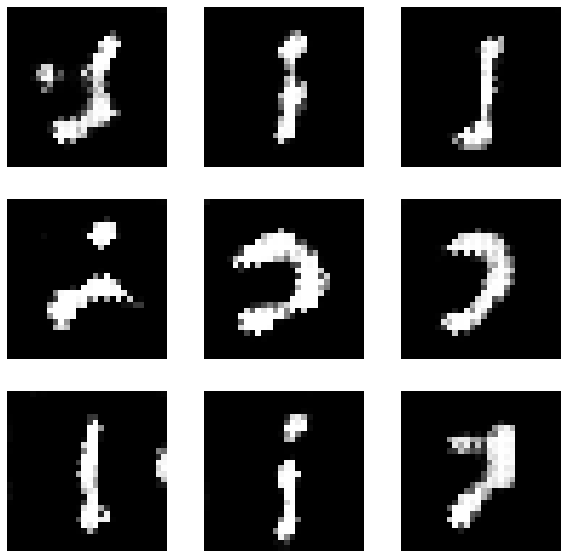

Epoch 2
Step 0. Ld=0.7519634962081909, Lg=1.5230810642242432, Pr=0.7550222873687744, Pf=0.732206404209137
Step 100. Ld=0.5038124918937683, Lg=1.8143441677093506, Pr=0.8395448923110962, Pf=0.7857503890991211
Step 200. Ld=0.7987543344497681, Lg=1.4069690704345703, Pr=0.7376952171325684, Pf=0.7230545282363892
Step 300. Ld=0.6438755989074707, Lg=1.552935004234314, Pr=0.7978013753890991, Pf=0.7460335493087769
Step 400. Ld=0.6961550712585449, Lg=2.0031070709228516, Pr=0.7443933486938477, Pf=0.8266685605049133
Step 500. Ld=0.7837951183319092, Lg=1.3416664600372314, Pr=0.7452709674835205, Pf=0.698756217956543
Step 600. Ld=0.6103214621543884, Lg=1.723996877670288, Pr=0.7699978351593018, Pf=0.7926149368286133
Step 700. Ld=0.8907652497291565, Lg=1.2965153455734253, Pr=0.718413233757019, Pf=0.6900867223739624
Step 800. Ld=0.5947021842002869, Lg=1.6326384544372559, Pr=0.791232705116272, Pf=0.7777156829833984
Step 900. Ld=0.6999363303184509, Lg=1.5707476139068604, Pr=0.7550508379936218, Pf=0.7572004

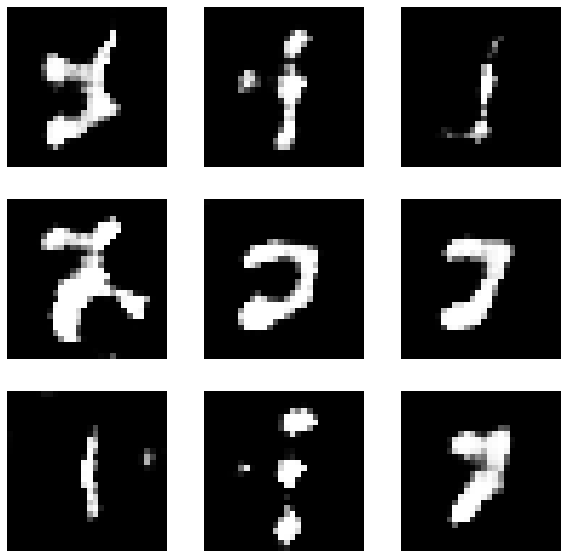

Epoch 3
Step 0. Ld=0.7176753878593445, Lg=1.6122256517410278, Pr=0.7383726835250854, Pf=0.7716876268386841
Step 100. Ld=0.7762196660041809, Lg=1.7126299142837524, Pr=0.688082754611969, Pf=0.7814739346504211
Step 200. Ld=0.781388521194458, Lg=1.7084788084030151, Pr=0.7017627358436584, Pf=0.7815013527870178
Step 300. Ld=0.9194581508636475, Lg=1.139733910560608, Pr=0.7344052791595459, Pf=0.6356558799743652
Step 400. Ld=0.8247846364974976, Lg=1.2188794612884521, Pr=0.7330899834632874, Pf=0.6680097579956055
Step 500. Ld=0.6829819083213806, Lg=1.516700267791748, Pr=0.7553985714912415, Pf=0.7455509305000305
Step 600. Ld=0.9137942790985107, Lg=1.2870972156524658, Pr=0.6868369579315186, Pf=0.6822106242179871
Step 700. Ld=0.7605846524238586, Lg=1.7299036979675293, Pr=0.6833810806274414, Pf=0.7975636124610901
Step 800. Ld=0.8322256803512573, Lg=1.3458900451660156, Pr=0.6785262823104858, Pf=0.7174792289733887
Step 900. Ld=0.642923891544342, Lg=1.9882826805114746, Pr=0.6928286552429199, Pf=0.842771

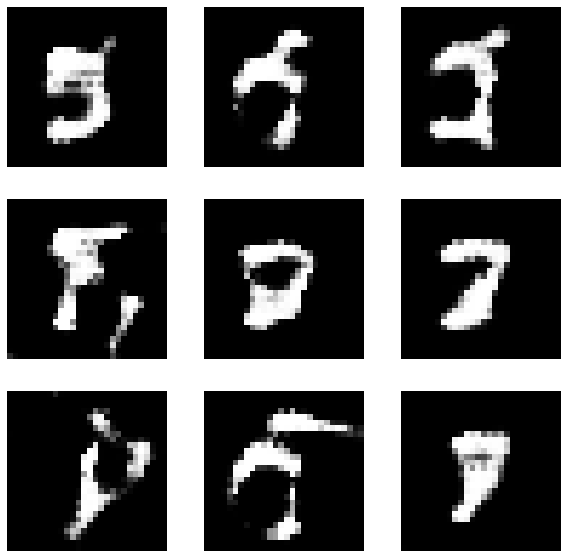

Epoch 4
Step 0. Ld=0.7158024311065674, Lg=1.4577438831329346, Pr=0.7490065097808838, Pf=0.7257229089736938
Step 100. Ld=0.8389317989349365, Lg=1.8026496171951294, Pr=0.6297225952148438, Pf=0.797042191028595
Step 200. Ld=0.9267209768295288, Lg=1.1732603311538696, Pr=0.6907060146331787, Pf=0.6418054103851318
Step 300. Ld=0.8139904737472534, Lg=1.4363508224487305, Pr=0.6968220472335815, Pf=0.7126277685165405
Step 400. Ld=0.7815626859664917, Lg=1.3602313995361328, Pr=0.7038421630859375, Pf=0.7078036069869995
Step 500. Ld=1.1452324390411377, Lg=1.1483474969863892, Pr=0.5844444632530212, Pf=0.6336206793785095
Step 600. Ld=0.8508901000022888, Lg=1.1204560995101929, Pr=0.7454595565795898, Pf=0.6305828094482422
Step 700. Ld=1.1046946048736572, Lg=1.1052992343902588, Pr=0.6480394601821899, Pf=0.6074187159538269
Step 800. Ld=1.1197503805160522, Lg=1.0799678564071655, Pr=0.6464451551437378, Pf=0.597457766532898
Step 900. Ld=0.646338164806366, Lg=1.2916231155395508, Pr=0.8029270172119141, Pf=0.6991

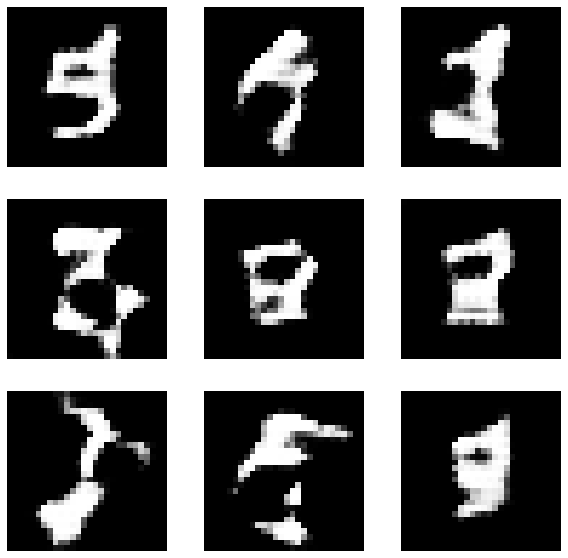

Epoch 5
Step 0. Ld=0.8599878549575806, Lg=1.3413865566253662, Pr=0.6919534802436829, Pf=0.6924417614936829
Step 100. Ld=1.102871298789978, Lg=1.0698760747909546, Pr=0.6517376899719238, Pf=0.6048408150672913
Step 200. Ld=0.9634073972702026, Lg=1.2703474760055542, Pr=0.6538476347923279, Pf=0.6639639735221863
Step 300. Ld=0.6008143424987793, Lg=1.623487114906311, Pr=0.7739641070365906, Pf=0.7533330917358398
Step 400. Ld=1.0703418254852295, Lg=1.0778417587280273, Pr=0.6537158489227295, Pf=0.6093625426292419
Step 500. Ld=0.6517421007156372, Lg=1.7521312236785889, Pr=0.7003316283226013, Pf=0.7891342639923096
Step 600. Ld=1.0816471576690674, Lg=0.996666669845581, Pr=0.6307344436645508, Pf=0.5996309518814087
Step 700. Ld=0.9211121201515198, Lg=1.3528318405151367, Pr=0.632503867149353, Pf=0.6979556083679199
Step 800. Ld=0.9926203489303589, Lg=1.1734097003936768, Pr=0.616645336151123, Pf=0.664137601852417
Step 900. Ld=1.417066216468811, Lg=0.7468762397766113, Pr=0.5913005471229553, Pf=0.49227195

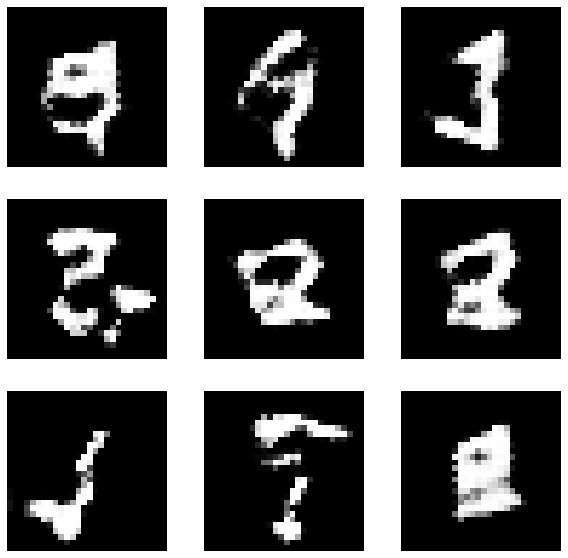

Epoch 6
Step 0. Ld=1.0863267183303833, Lg=1.066911220550537, Pr=0.6084963083267212, Pf=0.6241319179534912
Step 100. Ld=0.9906105995178223, Lg=1.264284610748291, Pr=0.6284042596817017, Pf=0.6752853989601135
Step 200. Ld=0.6637446880340576, Lg=1.5192632675170898, Pr=0.7288166284561157, Pf=0.7451463341712952
Step 300. Ld=1.2677040100097656, Lg=1.018547534942627, Pr=0.5632280111312866, Pf=0.5916697382926941
Step 400. Ld=0.9172915816307068, Lg=1.235553503036499, Pr=0.6866470575332642, Pf=0.6610386371612549
Step 500. Ld=0.9526031613349915, Lg=1.193710446357727, Pr=0.6333304047584534, Pf=0.6690828800201416
Step 600. Ld=1.2008439302444458, Lg=0.954778790473938, Pr=0.5860583782196045, Pf=0.5761639475822449
Step 700. Ld=0.7149535417556763, Lg=1.4123739004135132, Pr=0.7504500150680542, Pf=0.7056901454925537
Step 800. Ld=0.8483644723892212, Lg=1.1327626705169678, Pr=0.7132554054260254, Pf=0.6454207897186279
Step 900. Ld=1.054027795791626, Lg=1.0608184337615967, Pr=0.661025881767273, Pf=0.601671278

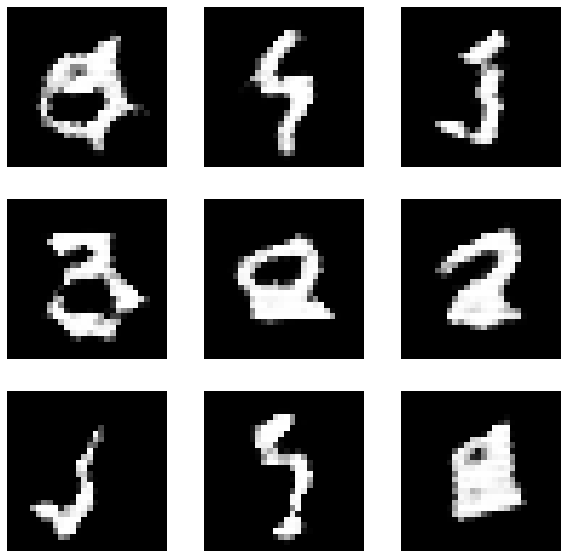

Epoch 7
Step 0. Ld=0.9730072021484375, Lg=1.147964358329773, Pr=0.657414436340332, Pf=0.6323594450950623
Step 100. Ld=1.0096511840820312, Lg=1.0692583322525024, Pr=0.684128999710083, Pf=0.6087789535522461
Step 200. Ld=0.8285143375396729, Lg=1.1962203979492188, Pr=0.7358850240707397, Pf=0.65229731798172
Step 300. Ld=0.9539183974266052, Lg=0.9375450611114502, Pr=0.7188125848770142, Pf=0.5752847790718079
Step 400. Ld=1.2999913692474365, Lg=0.7757190465927124, Pr=0.6245567798614502, Pf=0.5018276572227478
Step 500. Ld=0.9781771302223206, Lg=0.9701758027076721, Pr=0.7001340389251709, Pf=0.5855023860931396
Step 600. Ld=1.2336528301239014, Lg=0.8901787400245667, Pr=0.5894612073898315, Pf=0.5564519762992859
Step 700. Ld=1.1489171981811523, Lg=0.9688718318939209, Pr=0.6095519065856934, Pf=0.5918561220169067
Step 800. Ld=0.9197380542755127, Lg=1.2363144159317017, Pr=0.62013840675354, Pf=0.6824532747268677
Step 900. Ld=0.8882205486297607, Lg=1.4144049882888794, Pr=0.6236400604248047, Pf=0.71817839

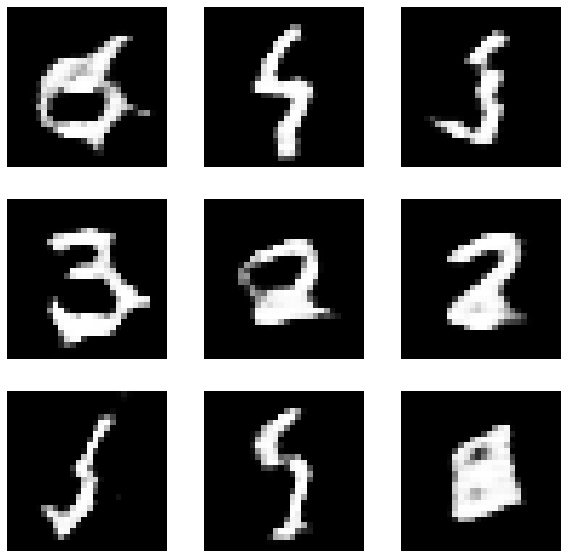

Epoch 8
Step 0. Ld=1.0524303913116455, Lg=0.9919096827507019, Pr=0.6661396622657776, Pf=0.5900706648826599
Step 100. Ld=1.1255149841308594, Lg=0.9927802085876465, Pr=0.6302608251571655, Pf=0.5836048126220703
Step 200. Ld=1.1559219360351562, Lg=1.0229828357696533, Pr=0.5841261148452759, Pf=0.6115558743476868
Step 300. Ld=1.1841330528259277, Lg=1.1139870882034302, Pr=0.563408374786377, Pf=0.6252337694168091
Step 400. Ld=1.0068731307983398, Lg=1.0165125131607056, Pr=0.6571425795555115, Pf=0.6078722476959229
Step 500. Ld=1.0439410209655762, Lg=1.0521332025527954, Pr=0.6428329348564148, Pf=0.6070284843444824
Step 600. Ld=1.1198623180389404, Lg=1.0731816291809082, Pr=0.57021164894104, Pf=0.6271699666976929
Step 700. Ld=1.245460033416748, Lg=1.1865665912628174, Pr=0.5108528137207031, Pf=0.661157488822937
Step 800. Ld=0.9943383932113647, Lg=1.033179521560669, Pr=0.6637284159660339, Pf=0.6104270219802856
Step 900. Ld=0.9243861436843872, Lg=1.237905740737915, Pr=0.6136743426322937, Pf=0.69051104

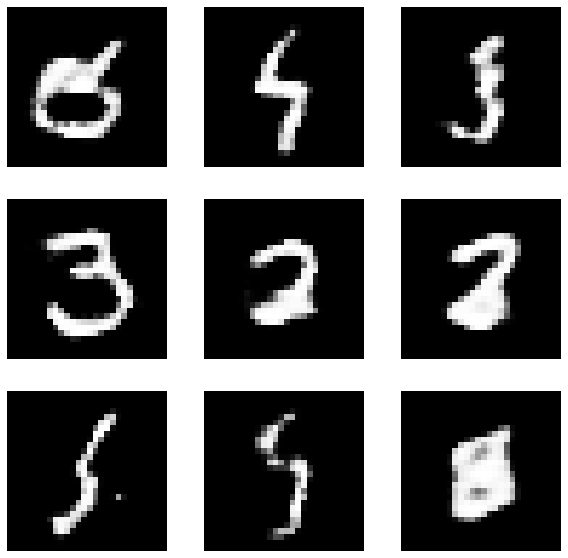

Epoch 9
Step 0. Ld=1.1626062393188477, Lg=1.044858455657959, Pr=0.5635757446289062, Pf=0.6168739795684814
Step 100. Ld=1.0068981647491455, Lg=1.3713927268981934, Pr=0.5642606019973755, Pf=0.714693546295166
Step 200. Ld=1.0590277910232544, Lg=1.0702974796295166, Pr=0.6115177273750305, Pf=0.6185547113418579
Step 300. Ld=1.1033434867858887, Lg=1.1618187427520752, Pr=0.5878746509552002, Pf=0.6447360515594482
Step 400. Ld=0.9462491273880005, Lg=1.1413378715515137, Pr=0.6333647966384888, Pf=0.6568254232406616
Step 500. Ld=1.1720621585845947, Lg=0.9178335070610046, Pr=0.618317723274231, Pf=0.562227725982666
Step 600. Ld=1.089948058128357, Lg=0.9082753658294678, Pr=0.6520208120346069, Pf=0.5697911977767944
Step 700. Ld=1.1754183769226074, Lg=1.2236883640289307, Pr=0.5329465866088867, Pf=0.6634138822555542
Step 800. Ld=0.9947521686553955, Lg=1.0116522312164307, Pr=0.6731982231140137, Pf=0.6025046110153198
Step 900. Ld=0.9958168268203735, Lg=0.9208313226699829, Pr=0.7040086984634399, Pf=0.569786

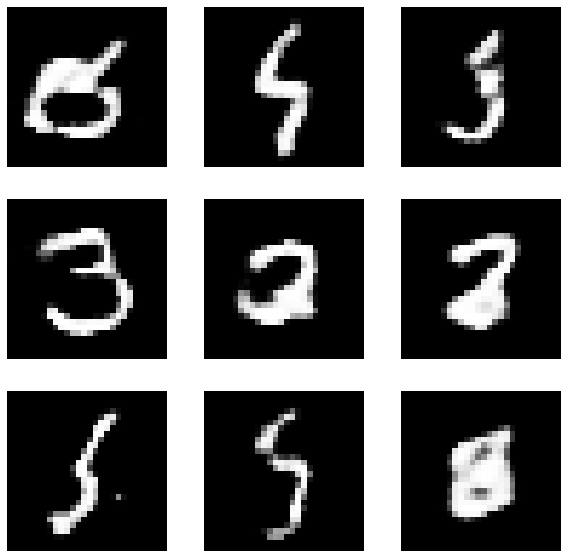

Epoch 10
Step 0. Ld=1.0408098697662354, Lg=0.9866344332695007, Pr=0.6395370364189148, Pf=0.6035128831863403
Step 100. Ld=1.1156383752822876, Lg=0.8162487745285034, Pr=0.7186397910118103, Pf=0.5163156986236572
Step 200. Ld=1.0532310009002686, Lg=0.8837518095970154, Pr=0.6677650809288025, Pf=0.5631518363952637
Step 300. Ld=0.9492436647415161, Lg=0.964625358581543, Pr=0.7135774493217468, Pf=0.586982250213623
Step 400. Ld=1.187182903289795, Lg=0.8504990339279175, Pr=0.6218621730804443, Pf=0.5451817512512207
Step 500. Ld=1.1223487854003906, Lg=0.9435784816741943, Pr=0.6187743544578552, Pf=0.5800803303718567
Step 600. Ld=1.1005432605743408, Lg=1.0319342613220215, Pr=0.61200350522995, Pf=0.6049212217330933
Step 700. Ld=1.1910542249679565, Lg=0.9533544778823853, Pr=0.5927062034606934, Pf=0.5781163573265076
Step 800. Ld=1.0601098537445068, Lg=1.2498323917388916, Pr=0.5677957534790039, Pf=0.6799957156181335
Step 900. Ld=1.1338298320770264, Lg=1.0223658084869385, Pr=0.5979980230331421, Pf=0.59948

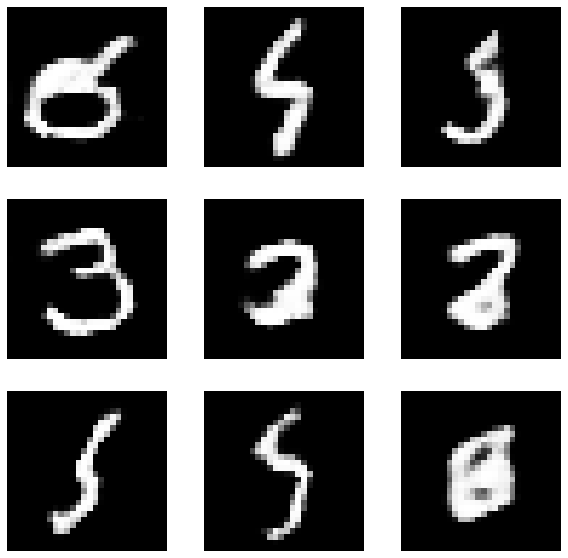

Epoch 11
Step 0. Ld=1.071207880973816, Lg=1.0327973365783691, Pr=0.6280050277709961, Pf=0.6138705015182495
Step 100. Ld=1.0784456729888916, Lg=0.9251453876495361, Pr=0.647816002368927, Pf=0.5789341926574707
Step 200. Ld=1.0857374668121338, Lg=0.9863492250442505, Pr=0.6232999563217163, Pf=0.5900843739509583
Step 300. Ld=1.0342144966125488, Lg=0.87096107006073, Pr=0.6975574493408203, Pf=0.5489206910133362
Step 400. Ld=1.044499158859253, Lg=1.1546134948730469, Pr=0.5968054533004761, Pf=0.6492117643356323
Step 500. Ld=0.927234411239624, Lg=1.1756701469421387, Pr=0.660071849822998, Pf=0.6558694839477539
Step 600. Ld=1.1901627779006958, Lg=0.8772349953651428, Pr=0.6241523027420044, Pf=0.5592365264892578
Step 700. Ld=1.0152130126953125, Lg=1.1786015033721924, Pr=0.6045050621032715, Pf=0.6511412262916565
Step 800. Ld=1.134853482246399, Lg=1.0261518955230713, Pr=0.5838310718536377, Pf=0.6090571880340576
Step 900. Ld=1.1207196712493896, Lg=0.9435179233551025, Pr=0.6103527545928955, Pf=0.58030062

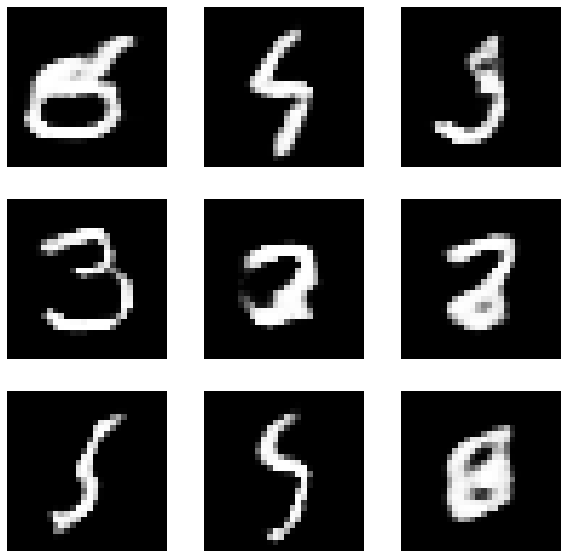

Epoch 12
Step 0. Ld=0.946709156036377, Lg=1.008946180343628, Pr=0.6792386174201965, Pf=0.6042091846466064
Step 100. Ld=1.1248983144760132, Lg=1.2088878154754639, Pr=0.5607529878616333, Pf=0.6663901805877686
Step 200. Ld=1.0590600967407227, Lg=0.8697768449783325, Pr=0.6982783079147339, Pf=0.5448862910270691
Step 300. Ld=0.965815544128418, Lg=1.0008623600006104, Pr=0.6972368955612183, Pf=0.5939005613327026
Step 400. Ld=1.1020268201828003, Lg=0.9188989400863647, Pr=0.6400274634361267, Pf=0.5741666555404663
Step 500. Ld=1.1337699890136719, Lg=1.0277928113937378, Pr=0.6150777339935303, Pf=0.5968251824378967
Step 600. Ld=1.0396554470062256, Lg=1.0782649517059326, Pr=0.639116644859314, Pf=0.6176791191101074
Step 700. Ld=1.197042465209961, Lg=1.0884034633636475, Pr=0.5690515637397766, Pf=0.6177908182144165
Step 800. Ld=1.0258339643478394, Lg=1.455495834350586, Pr=0.5563770532608032, Pf=0.7234551310539246
Step 900. Ld=1.020932912826538, Lg=1.182481288909912, Pr=0.61269211769104, Pf=0.6502156853

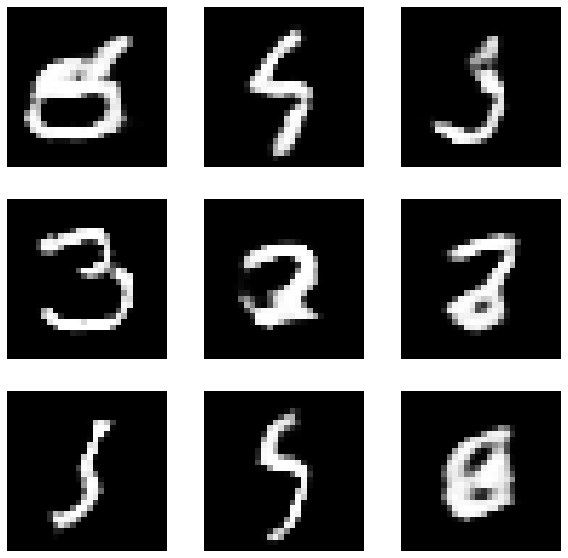

Epoch 13
Step 0. Ld=1.1423488855361938, Lg=0.9812009930610657, Pr=0.6219989657402039, Pf=0.5846194624900818
Step 100. Ld=1.0595433712005615, Lg=1.1523003578186035, Pr=0.5806270837783813, Pf=0.6567175388336182
Step 200. Ld=1.1066436767578125, Lg=1.046236276626587, Pr=0.5999935865402222, Pf=0.6110339164733887
Step 300. Ld=1.026489019393921, Lg=1.2154546976089478, Pr=0.5949739813804626, Pf=0.6656227707862854
Step 400. Ld=1.1638000011444092, Lg=0.8483995199203491, Pr=0.6279063820838928, Pf=0.5459274053573608
Step 500. Ld=1.0165575742721558, Lg=1.1821691989898682, Pr=0.5819581747055054, Pf=0.6640794277191162
Step 600. Ld=0.970487654209137, Lg=1.1094305515289307, Pr=0.6556918621063232, Pf=0.6323121786117554
Step 700. Ld=1.2466166019439697, Lg=0.8178679347038269, Pr=0.6056009531021118, Pf=0.5290709137916565
Step 800. Ld=1.0713715553283691, Lg=1.0838987827301025, Pr=0.6110212802886963, Pf=0.6300496459007263
Step 900. Ld=1.0330225229263306, Lg=0.9471362829208374, Pr=0.6551755666732788, Pf=0.584

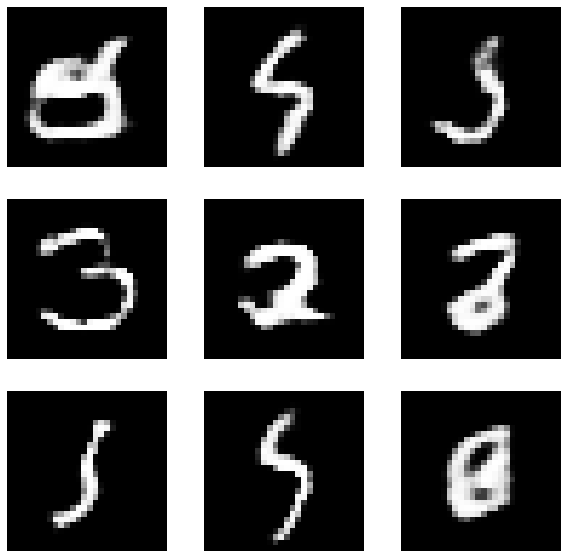

Epoch 14
Step 0. Ld=1.128156065940857, Lg=1.0314278602600098, Pr=0.6033895611763, Pf=0.6117292642593384
Step 100. Ld=1.110694169998169, Lg=1.082709789276123, Pr=0.5997937321662903, Pf=0.616798460483551
Step 200. Ld=1.0333012342453003, Lg=0.9889276623725891, Pr=0.6568113565444946, Pf=0.5965238213539124
Step 300. Ld=1.1057782173156738, Lg=1.022568941116333, Pr=0.6124052405357361, Pf=0.6018832921981812
Step 400. Ld=1.1238800287246704, Lg=0.9723159670829773, Pr=0.6267837285995483, Pf=0.5887686014175415
Step 500. Ld=1.1217961311340332, Lg=1.2077012062072754, Pr=0.5292257070541382, Pf=0.6781578063964844
Step 600. Ld=1.1040527820587158, Lg=1.0532630681991577, Pr=0.6157523393630981, Pf=0.6111007928848267
Step 700. Ld=1.1456515789031982, Lg=1.4996342658996582, Pr=0.4767328202724457, Pf=0.7529906034469604
Step 800. Ld=1.1184520721435547, Lg=1.0448435544967651, Pr=0.6037261486053467, Pf=0.6125553250312805
Step 900. Ld=1.0871458053588867, Lg=0.8630729913711548, Pr=0.659180223941803, Pf=0.552426278

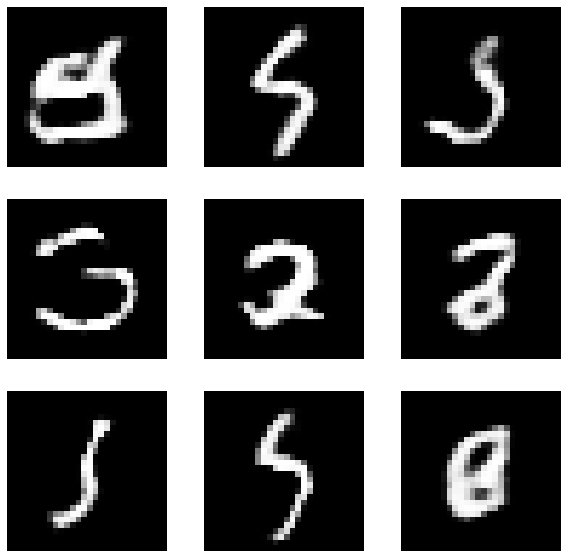

Epoch 15
Step 0. Ld=1.1592199802398682, Lg=1.267717719078064, Pr=0.5298963785171509, Pf=0.6695820093154907
Step 100. Ld=1.0601344108581543, Lg=1.079977035522461, Pr=0.6139652132987976, Pf=0.6216490864753723
Step 200. Ld=1.0769059658050537, Lg=0.8551437854766846, Pr=0.6728687286376953, Pf=0.5449870824813843
Step 300. Ld=1.1395989656448364, Lg=0.7941068410873413, Pr=0.6840680837631226, Pf=0.5198551416397095
Step 400. Ld=1.2160508632659912, Lg=0.9374668002128601, Pr=0.5951621532440186, Pf=0.5768155455589294
Step 500. Ld=1.0590356588363647, Lg=1.031554937362671, Pr=0.6172305345535278, Pf=0.6134456396102905
Step 600. Ld=1.1188600063323975, Lg=0.9391874074935913, Pr=0.6398996114730835, Pf=0.5705457925796509
Step 700. Ld=1.1529253721237183, Lg=0.8655246496200562, Pr=0.6478984951972961, Pf=0.5455069541931152
Step 800. Ld=1.1256136894226074, Lg=1.0972046852111816, Pr=0.5777935981750488, Pf=0.6279104948043823
Step 900. Ld=1.037419319152832, Lg=1.3107956647872925, Pr=0.5669960975646973, Pf=0.6930

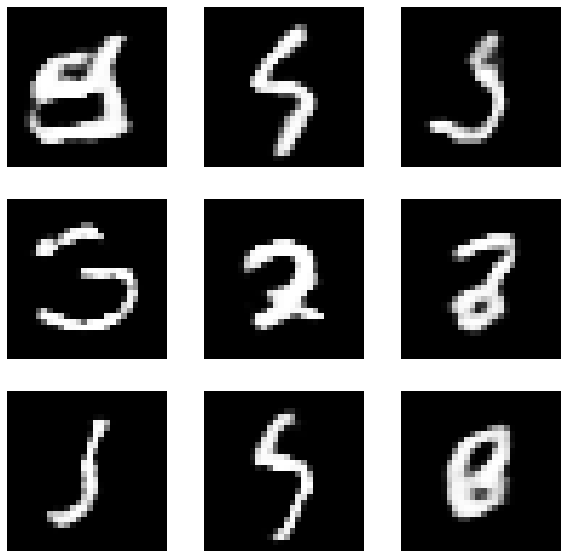

Epoch 16
Step 0. Ld=1.0369391441345215, Lg=1.1830589771270752, Pr=0.610577404499054, Pf=0.6409255266189575
Step 100. Ld=1.1477560997009277, Lg=1.1685020923614502, Pr=0.5547125339508057, Pf=0.6472935080528259
Step 200. Ld=1.0780291557312012, Lg=0.9583640098571777, Pr=0.6528927683830261, Pf=0.5792296528816223
Step 300. Ld=1.0704069137573242, Lg=1.0649218559265137, Pr=0.6092031002044678, Pf=0.6245695948600769
Step 400. Ld=1.0733898878097534, Lg=0.8788762092590332, Pr=0.6899641752243042, Pf=0.5481301546096802
Step 500. Ld=1.0018019676208496, Lg=1.124398112297058, Pr=0.611979067325592, Pf=0.6480748057365417
Step 600. Ld=1.098507046699524, Lg=1.160996913909912, Pr=0.5740171670913696, Pf=0.6542813777923584
Step 700. Ld=1.1147881746292114, Lg=1.2066168785095215, Pr=0.5367431044578552, Pf=0.6693391799926758
Step 800. Ld=1.0050573348999023, Lg=1.1845144033432007, Pr=0.6249651908874512, Pf=0.6436983346939087
Step 900. Ld=1.0157179832458496, Lg=1.110785961151123, Pr=0.6244179010391235, Pf=0.635488

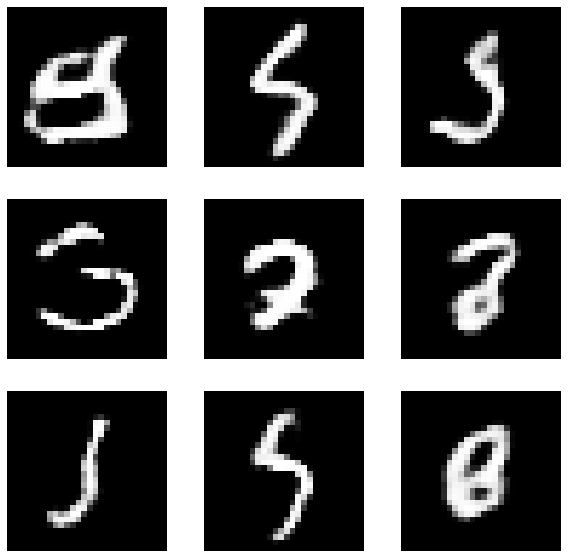

Epoch 17
Step 0. Ld=1.117278814315796, Lg=0.838748037815094, Pr=0.6989542245864868, Pf=0.5261738300323486
Step 100. Ld=1.149885654449463, Lg=1.0086755752563477, Pr=0.6104685068130493, Pf=0.5916879773139954
Step 200. Ld=0.9792085886001587, Lg=1.1654924154281616, Pr=0.6243129372596741, Pf=0.6527249217033386
Step 300. Ld=1.2385900020599365, Lg=1.04744553565979, Pr=0.5609742403030396, Pf=0.6122338175773621
Step 400. Ld=1.0849014520645142, Lg=1.126503825187683, Pr=0.5878469944000244, Pf=0.6374582648277283
Step 500. Ld=1.094151496887207, Lg=1.1286765336990356, Pr=0.5848687887191772, Pf=0.6314045786857605
Step 600. Ld=1.117140293121338, Lg=1.1276135444641113, Pr=0.5704589486122131, Pf=0.6414494514465332
Step 700. Ld=1.1331580877304077, Lg=1.0020027160644531, Pr=0.6090795397758484, Pf=0.5926588773727417
Step 800. Ld=1.0656960010528564, Lg=1.1479213237762451, Pr=0.5961260199546814, Pf=0.6422613263130188
Step 900. Ld=1.1230487823486328, Lg=1.2656276226043701, Pr=0.5296011567115784, Pf=0.67872732

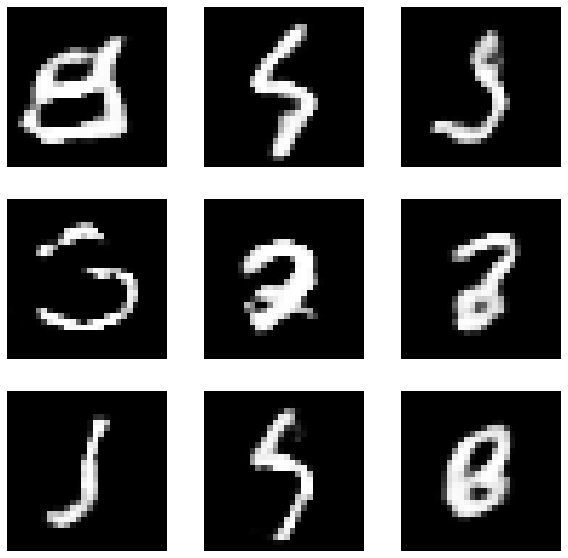

Epoch 18
Step 0. Ld=1.0988857746124268, Lg=1.0091168880462646, Pr=0.6153449416160583, Pf=0.609282374382019
Step 100. Ld=1.0078911781311035, Lg=1.0275455713272095, Pr=0.6307858824729919, Pf=0.6194039583206177
Step 200. Ld=1.0280828475952148, Lg=0.8312109708786011, Pr=0.7081344127655029, Pf=0.5393471121788025
Step 300. Ld=1.0288658142089844, Lg=1.191058874130249, Pr=0.6141402721405029, Pf=0.6455230116844177
Step 400. Ld=1.1196198463439941, Lg=0.8944016695022583, Pr=0.6317431330680847, Pf=0.5650259256362915
Step 500. Ld=0.929436445236206, Lg=1.4071754217147827, Pr=0.5944909453392029, Pf=0.7174021005630493
Step 600. Ld=1.1853058338165283, Lg=1.1145201921463013, Pr=0.5639046430587769, Pf=0.6362833380699158
Step 700. Ld=1.0870025157928467, Lg=0.9194072484970093, Pr=0.665475606918335, Pf=0.5587118268013
Step 800. Ld=1.0762184858322144, Lg=1.0741161108016968, Pr=0.610680103302002, Pf=0.6221098899841309
Step 900. Ld=1.0873699188232422, Lg=0.9521774053573608, Pr=0.6357699632644653, Pf=0.58395707

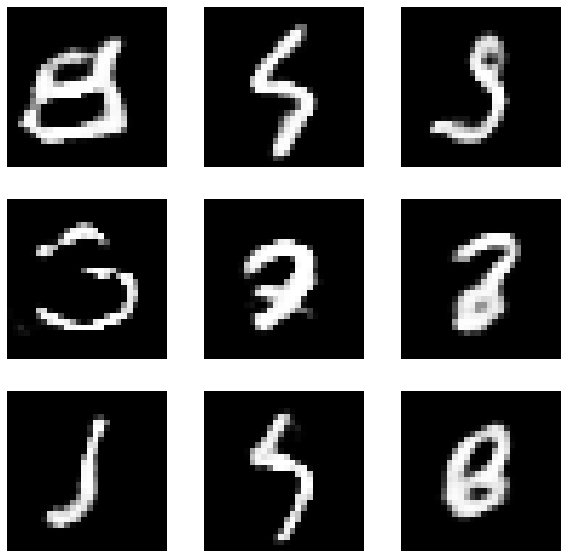

Epoch 19
Step 0. Ld=1.0330283641815186, Lg=1.1609288454055786, Pr=0.5953803062438965, Pf=0.6498722434043884
Step 100. Ld=0.9779767990112305, Lg=1.0864454507827759, Pr=0.6366024017333984, Pf=0.6351968050003052
Step 200. Ld=0.9733200073242188, Lg=1.178656816482544, Pr=0.6302164793014526, Pf=0.6534407138824463
Step 300. Ld=0.9913941621780396, Lg=1.0176432132720947, Pr=0.6641905307769775, Pf=0.6040101051330566
Step 400. Ld=0.9862017035484314, Lg=0.9630725979804993, Pr=0.6855126023292542, Pf=0.5917630195617676
Step 500. Ld=1.088202714920044, Lg=1.074354648590088, Pr=0.6032396554946899, Pf=0.6212365627288818
Step 600. Ld=1.0628767013549805, Lg=1.186410903930664, Pr=0.6149784326553345, Pf=0.6652100086212158
Step 700. Ld=1.0637202262878418, Lg=1.3078081607818604, Pr=0.5542151927947998, Pf=0.6991448998451233
Step 800. Ld=0.956011176109314, Lg=1.40006685256958, Pr=0.5960291624069214, Pf=0.7140709161758423
Step 900. Ld=1.0600851774215698, Lg=1.0112998485565186, Pr=0.6572945713996887, Pf=0.5895727

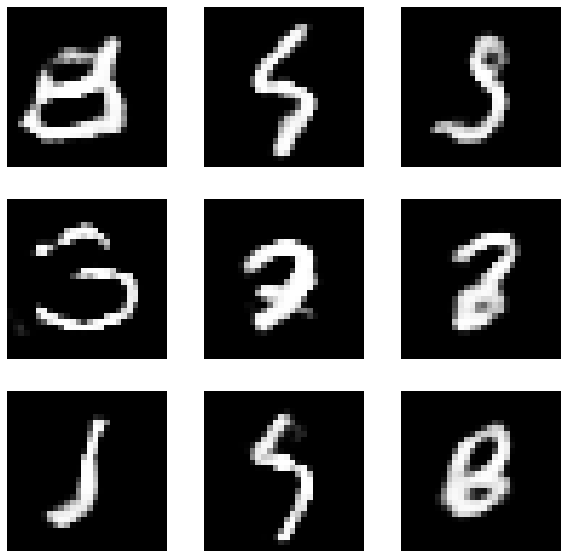

In [11]:
EPOCHS = 20

noise_for_training_visualization = generate_noise(noise_dim, batch_size = 9)

for epoch in range(EPOCHS):

  print("Epoch", epoch),

  for step, (x_train, _) in enumerate(dataset):
    Ld, Lg, Pr, Pf = train_step(x_train)

    if step % 100 == 0:
      print("Step {}. Ld={}, Lg={}, Pr={}, Pf={}".format(step, Ld, Lg, Pr, Pf))

  show_image_grid(generator(noise_for_training_visualization).numpy())

  

In [12]:
# Denne kan du bruke til å utforske generatoren!

from ipywidgets import interact

p1 = generate_noise(noise_dim)
p2 = generate_noise(noise_dim)
p3 = generate_noise(noise_dim)

@interact(k1=(0, 1.0), k2=(0, 1.0))
def g(k1, k2):
    p = p1 + k1 * (p2 - p1) + k2 * (p3 - p1)
    show_image(generator(p).numpy())

interactive(children=(FloatSlider(value=0.5, description='k1', max=1.0), FloatSlider(value=0.5, description='k…